# Obtain the saliency map of a trained CNN

Here we use the ResNet model trained to distinguish between Shih-Tzu (214 images) and Blenheim spaniel (188 images).

In [1]:
import torch
from torch import nn
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os

torch.manual_seed(53)
np.random.seed(432)

%matplotlib inline

## Load the trained model

In [2]:
# download resnet18 and modify to match the fully connected layers' structure
model = models.resnet18()
model.fc = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(256, 2),
                         nn.LogSoftmax(dim=1))
model.load_state_dict(torch.load('ResNet_DogBreeds.pt'))

<All keys matched successfully>

## Define the calculation for saliency map

In [3]:
def saliency(image, model):
    """
    https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb
    """
    # We don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    # Set model in eval mode
    model.eval()

    # Transoform input PIL image to torch.Tensor and normalize
    means = [0.4652, 0.4316, 0.3783]
    stds  = [0.1084, 0.1037, 0.1108]

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=means,
                                std=stds)
    ])
    transform2 = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

    input = transform(image)
    input.unsqueeze_(0)

    # Calculate the gradient of the score of the predicted class w.r.t. the input image
    # (1) Set requires_grad to True to make the loss function differentiable 
    # w.r.t. the input image
    input.requires_grad = True

    # (2) Forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)

    # (3) Backward pass to calculate the gradients
    score.backward()

    # (4) get max activation across channel axis
    # print(input.grad.shape)
    # >>> torch.Size([1, 3, 224, 224])
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)

    # (5) Normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    # (6) Plot image and its saleincy map
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    ax = axes[0]
    ax.imshow(np.transpose(transform2(image).detach().numpy(), (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1]
    plt.imshow(slc.numpy(), cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])

## Apply the saliency procedure on various images

In [4]:
root = 'C:/Users/ywang254/OneDrive - University of Tennessee/Teaching/JupyterNotebooks/data/DogBreeds'

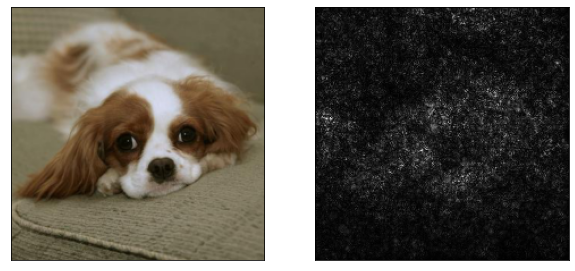

In [5]:
img = Image.open(os.path.join(root, 'Blenheim_spaniel', 'n02086646_20.jpg')).convert('RGB')
saliency(img, model)

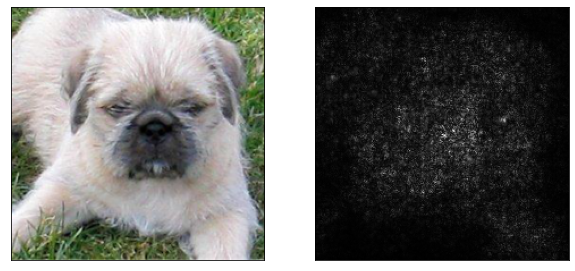

In [6]:
img = Image.open(os.path.join(root, 'Shih-Tzu', 'n02086240_599.jpg')).convert('RGB')
saliency(img, model)

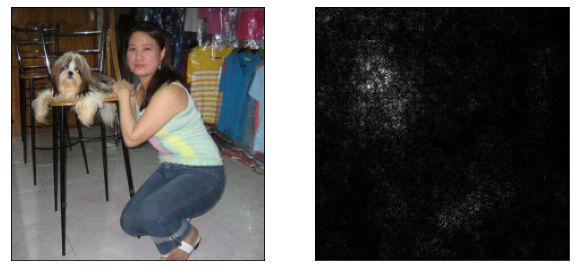

In [7]:
img = Image.open(os.path.join(root, 'Shih-Tzu', 'n02086240_457.jpg')).convert('RGB')
saliency(img, model)